# NN autoencoder on Frame Spectrum data 

Taken from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py


In [1]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget
from scipy.io import wavfile
import librosa
import tensorflow as tf
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'

filename = path+fname

In [40]:
from scipy.signal import resample
# Read wav file to floating values
fs_orig,x = wavfile.read(filename)
fs = 22050/2
x = resample(x, x.size*fs/fs_orig)

t1 = 2*fs
t2 = 300*fs
x = x[t1:t2]
x = np.float64(x)/2**15
# Peak Normalization

x/=abs(x).max()

# Extract overlapping frames and create a spectrogram in each one

L = x.size

frame_size = 2**16
step_size = int(frame_size/2)

# Number of frames
# n_frames = int( (L-frame_size)/step_size+1 )

block_size = 2**10
hop = int(block_size/4)
NFFT = block_size

level_threshold = 1e-4

# n_blocks = int( (frame_size-block_size)/hop)+1+ int(block_size/hop)

#STFT or CQT
representation = ['STFT','CQT'][0]
units = ['lineal','db'][0]

if representation=='STFT':
    # STFT
    
    S = abs(librosa.stft(x,n_fft=NFFT,hop_length=hop,win_length=block_size )/2/NFFT)
        

elif representation=='CQT':
    # CQT
    n_bins = 84
    
    S = abs(librosa.cqt(x,sr=fs,hop_length=hop,fmin=40.0,n_bins=n_bins,real=False))
        

if units=='db':
    S = 20*log10(abs(S)).clip(-60,0)

S = (S - S.min(0)) /(S.max(0) - S.min(0))

print("Dimensions: frames, freq bins, time bins")
S = np.array(S)
freq_bins, batch_length = S.shape
print(batch_length, freq_bins)


/usr/local/lib/python3.4/dist-packages/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


Dimensions: frames, freq bins, time bins
5886 513


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [48]:

data = Data( S.T )
n_spectrums = data.length


In [55]:
# Parameters
learning_rate = 0.01
training_epochs = 200
batch_size = 2**11

display_step = 5

# Network Parameters
dimensions= [256,128,64]

n_input = data.data.shape[1]

In [56]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {}
biases = {}
layer_input = n_input

for layer_i, layer_output in enumerate(dimensions[:]):
    weights['encoder_h'+str(layer_i)] = tf.Variable(tf.random_normal([layer_input, layer_output]))
    biases['encoder_b'+str(layer_i)] = tf.Variable(tf.random_normal([layer_output]))
    layer_input = layer_output

for layer_i, layer_output in enumerate(dimensions[:-1][::-1]+[n_input]):
    weights['decoder_h'+str(layer_i)] = tf.Variable(tf.random_normal([layer_input, layer_output]))
    biases['decoder_b'+str(layer_i)] = tf.Variable(tf.random_normal([layer_output]))
    layer_input = layer_output
    
shape = tf.nn.sigmoid

# Building the encoder
layers = {}
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_input = x
    
    for layer_i, layer_output in enumerate(dimensions[:]):
        layers[layer_i] = shape(tf.add(tf.matmul(layer_input, weights['encoder_h'+str(layer_i)]), 
                                               biases['encoder_b'+str(layer_i)]))
        layer_input = layers[layer_i]

    return layer_input


# Building the decoder
def decoder(x):

    layer_input = x
    for layer_i, layer_output in enumerate(dimensions[:]):
        layers[layer_i] = shape(tf.add(tf.matmul(layer_input, weights['decoder_h'+str(layer_i)]), 
                                               biases['decoder_b'+str(layer_i)]))
        layer_input = layers[layer_i]

    return layer_input

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

In [57]:
# Launch the graph
config = tf.ConfigProto( device_count = {'GPU': 0} )
sess = tf.Session(config=config)
sess.run(init)
total_batch = int(data.length/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = data.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        opt,cost_value = sess.run([optimizer, cost], feed_dict={X: batch_xs})

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(cost_value))

print("Optimization Finished!")

Epoch: 0001 cost= 0.340457082
Epoch: 0006 cost= 0.142090127
Epoch: 0011 cost= 0.107989505
Epoch: 0016 cost= 0.099700660
Epoch: 0021 cost= 0.091946729
Epoch: 0026 cost= 0.089827292
Epoch: 0031 cost= 0.085279703
Epoch: 0036 cost= 0.082175389
Epoch: 0041 cost= 0.077592313
Epoch: 0046 cost= 0.073783934
Epoch: 0051 cost= 0.071032651
Epoch: 0056 cost= 0.069817722
Epoch: 0061 cost= 0.068408214
Epoch: 0066 cost= 0.067320727
Epoch: 0071 cost= 0.067333497
Epoch: 0076 cost= 0.063732766
Epoch: 0081 cost= 0.063289419
Epoch: 0086 cost= 0.062888280
Epoch: 0091 cost= 0.062450863
Epoch: 0096 cost= 0.062467996
Epoch: 0101 cost= 0.061739314
Epoch: 0106 cost= 0.061517607
Epoch: 0111 cost= 0.061423909
Epoch: 0116 cost= 0.061226938
Epoch: 0121 cost= 0.061262827
Epoch: 0126 cost= 0.059762906
Epoch: 0131 cost= 0.059481066
Epoch: 0136 cost= 0.057573352
Epoch: 0141 cost= 0.057486556
Epoch: 0146 cost= 0.057511002
Epoch: 0151 cost= 0.057469353
Epoch: 0156 cost= 0.055394001
Epoch: 0161 cost= 0.055204894
Epoch: 016

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


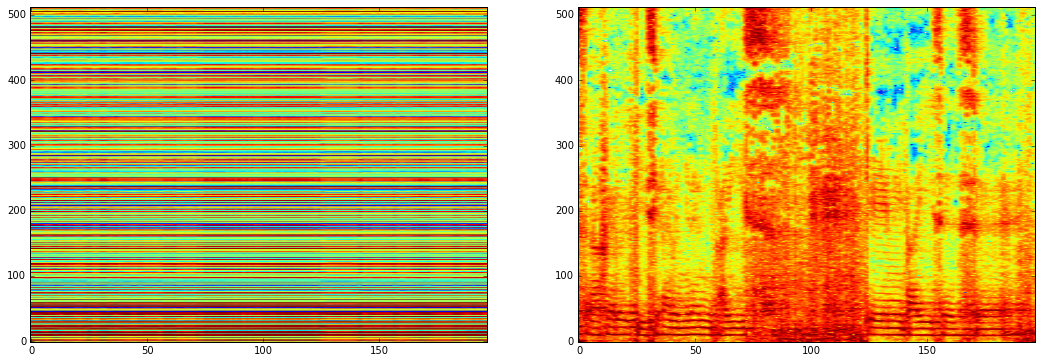

In [58]:
range_ = range(3,200)
original = data.data[range_]
figure(figsize=(18,6))
out = sess.run(y_pred, feed_dict={X: original})

subplot(1,2,1)
imshow(np.log10(out.T),aspect='auto',origin='bottom')
subplot(1,2,2)
imshow(np.log10(original.T),aspect='auto',origin='bottom')


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


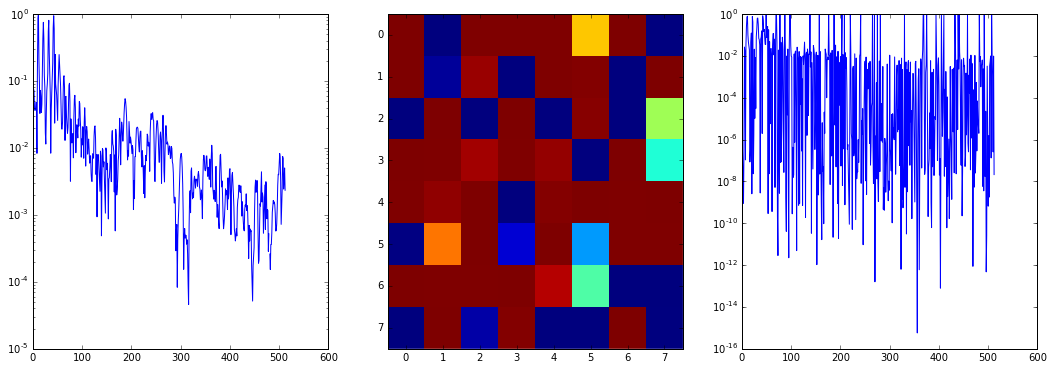

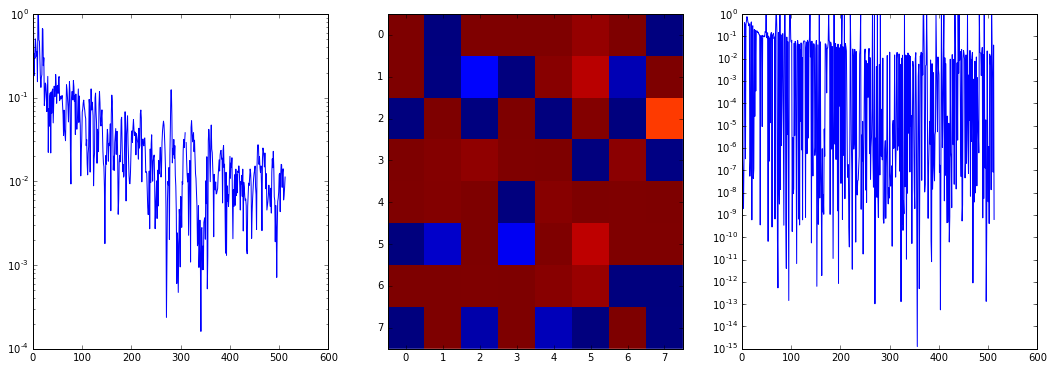

In [54]:
inputs = [data.data[50:51],data.data[100:101]]

for i,input_ in enumerate(inputs):
    figure(figsize=(18,6))
    subplot(1,3,1)
    semilogy(input_.T)  
    middle,out = sess.run([encoder_op,y_pred], feed_dict={X: input_})
    subplot(1,3,2)
    imshow(middle.reshape((8,dimensions[-1]/8)),aspect='auto',interpolation='none')
    subplot(1,3,3)
    semilogy(out.T)


In [39]:
data.data[0].max()

0.0015491918